In [ ]:
import random
import re
from collections import defaultdict
import nltk
import pandas as pd
import math
import matplotlib.pyplot as plt
import random


nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/imanghotbi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Read the data
with open("Data/twits.txt", "r", encoding="utf-8") as f:
    data = f.read()

print("Data type:", type(data))
# Sentence count
sentence_count = data.count('.') + data.count('!') + data.count('?')
print("Number of sentences:", sentence_count)
# Word count
word_count = len(data.split())
print("Number of words:", word_count)
print("Number of characters:", len(data))
print("--"*50)
print("First 500 characters:\n", data[:500])

Data type: <class 'str'>
Number of sentences: 84674
Number of words: 601708
Number of characters: 3256325
----------------------------------------------------------------------------------------------------
First 500 characters:
 How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to see you. Been way, way too long.
When you meet someone special... you'll know. Your heart will beat more rapidly and you'll smile for no reason.
they've decided its more fun if I don't.
So Tired D; Played Lazer Tag & Ran A LOT D; Ughh Going To Sleep Like In 5 Minutes ;)
Words from a complete stranger! Made my birthday even better :)
First Cubs game ever! Wrigley field is gorgeous. This is perfect. Go Cubs Go!
i no! i ge


In [20]:
def preprocess_text(text):
    """
    Preprocess the input text: lowercase, remove special characters, and tokenize sentences.
    Returns: A list of lists, where each inner list contains the words of a sentence.
    """    
    # 1. Convert all text to lowercase
    text = text.lower()
    
    # 2. Tokenize text into sentences (using NLTK's punkt)
    raw_sentences = nltk.sent_tokenize(text)
    
    sentences = []
    
    for sent in raw_sentences:
        # 3. Remove punctuation/special characters
        clean_sent = re.sub(r'[^\w\s]', '', sent)
        
        # 4. Tokenize the cleaned sentence into words
        words = clean_sent.split()
        
        # Only append non-empty sentences
        if words:
            sentences.append(words)
            
    return sentences

# Preprocess the data
sentences = preprocess_text(data)

# Display the first 5 sentences
print("\nPreprocessed Sentences:")
print(sentences[:5])


Preprocessed Sentences:
[['how', 'are', 'you'], ['btw', 'thanks', 'for', 'the', 'rt'], ['you', 'gonna', 'be', 'in', 'dc', 'anytime', 'soon'], ['love', 'to', 'see', 'you'], ['been', 'way', 'way', 'too', 'long']]


In [5]:
def replace_oov_words_by_unk(tokenized_sentences, vocabulary, unknown_token="<unk>"):
    """
    Replace words not in the given vocabulary with '<unk>' token.
    """
    # Convert vocabulary to a set for faster lookup
    vocabulary_set = set(vocabulary)
    
    replaced_sentences = []
    
    for sentence in tokenized_sentences:
        temp_sentence = []
        for word in sentence:
            if word in vocabulary_set:
                temp_sentence.append(word)
            else:
                temp_sentence.append(unknown_token)
        replaced_sentences.append(temp_sentence)

    return replaced_sentences

In [21]:

def get_words_with_nplus_frequency(data, n):
    """
    Get words appearing n or more times in the data.
    """
    word_counts = defaultdict(int)
    
    # Flatten the list of lists to count words
    for sentence in data:
        for word in sentence:
            word_counts[word] += 1
            
    # Filter words that meet the frequency threshold
    vocab = [word for word, count in word_counts.items() if count >= n]
    
    return vocab

In [40]:
def preprocess_data(train_data, count_threshold):
    """
    Preprocess data to handle out-of-vocabulary words by replacing them with <unk>.
    """
    # Get the vocabulary based on the training data frequency
    vocabulary = get_words_with_nplus_frequency(train_data, count_threshold)
    
    # Replace words not in this vocabulary with <unk>
    train_data_replaced = replace_oov_words_by_unk(train_data, vocabulary)

    return train_data_replaced, vocabulary


# Apply preprocessing
# Split data: 80% Training, 20% Testing
random.seed(42) 
random.shuffle(sentences)

train_sentences = sentences[:int(0.8 * len(sentences))]
test_sentences = sentences[int(0.8 * len(sentences)):]

print("Data shuffled and split successfully.")

# Process Training Data
train_sentences_replaced, vocabulary = preprocess_data(train_sentences, count_threshold=3)

# Process Test Data (using the vocabulary derived from Training Data)
test_sentences_replaced = replace_oov_words_by_unk(test_sentences, vocabulary)

print(f"Vocabulary size: {len(vocabulary)}")
print(f"Training set size: {len(train_sentences_replaced)}")
print(f"Test set size: {len(test_sentences_replaced)}")

Data shuffled and split successfully.
Vocabulary size: 9977
Training set size: 43312
Test set size: 10828


In [41]:
def generate_ngrams(tokens, n):
    """
    Generate n-grams from a list of tokens.
    Returns: A list of tuples, where each tuple is an n-gram.
    """
    if len(tokens) < n:
        return []
        
    # Use list comprehension to create slices of length n
    ngrams = [tuple(tokens[i : i + n]) for i in range(len(tokens) - n + 1)]
    
    return ngrams

In [42]:
def build_ngram_model(sentences, n):
    """
    Build an n-gram model from the tokenized sentences.
    Returns: A dictionary where keys are (n-1)-grams and values are dictionaries of next words and their counts.
    """
    model = defaultdict(lambda: defaultdict(int))
    
    for sentence in sentences:
        # Generate n-grams for the current sentence
        # We assume generate_ngrams from the previous step is available
        ngrams = generate_ngrams(sentence, n)
        
        for ngram in ngrams:
            # The context is the first n-1 words
            context = tuple(ngram[:-1])
            # The target is the last word
            target = ngram[-1]
            
            model[context][target] += 1
            
    return model

# Build the n-gram model
n = 3
ngram_model = build_ngram_model(train_sentences_replaced, n)

# Display a sample of the n-gram model
print("\nN-gram Model (Sample):")
for key, value in list(ngram_model.items())[:5]:
    print(f"{key}: {value}")


N-gram Model (Sample):
('come', 'visit'): defaultdict(<class 'int'>, {'in': 1, 'for': 1, 'me': 1, 'and': 1, 'us': 1, 'the': 2, 'my': 1, 'asap': 1, 'jeff': 1, 'sometime': 1})
('visit', 'in'): defaultdict(<class 'int'>, {'the': 1})
('in', 'the'): defaultdict(<class 'int'>, {'teen': 1, 'hospital': 3, 'press': 2, 'past': 10, 'new': 7, 'nfl': 6, 'news': 2, 'market': 1, 'us': 14, 'shopping': 1, 'ncaa': 2, 'near': 5, 'hair': 1, 'morning': 27, '<unk>': 160, 'mil': 1, 'day': 9, 'bfs': 1, 'pdx': 1, 'fourth': 2, 'dm': 2, 'room': 14, 'great': 1, 'mainstream': 1, '70s': 3, 'forecast': 1, 'world': 59, 'case': 2, 'classroom': 4, 'eu': 1, 'italy': 1, 'purchase': 1, 'midwest': 3, 'denver': 2, 'mix': 3, 'top': 8, 'mail': 14, 'coaches': 1, 'imagination': 1, 'industry': 2, 'woods': 5, 'store': 1, 'area': 10, 'running': 1, 'post': 3, 'city': 13, 'north': 1, 'western': 1, 'movie': 1, 'body': 2, '20s': 1, 'am': 7, 'hunger': 2, 'backseat': 2, 'gimme': 1, 'seats': 1, 'session': 1, 'background': 3, 'mood': 6, 

In [43]:
def generate_sentence_no_unk(ngram_model, n, start_word=None, max_length=15):
    # 1. Start with a random context (same as before)
    if start_word:
        valid_start_contexts = [ctx for ctx in ngram_model.keys() if ctx[0] == start_word]
        if not valid_start_contexts:
            return "Error: Start word not found."
        start_context = random.choice(valid_start_contexts)
    else:
        start_context = random.choice(list(ngram_model.keys()))
    
    result = list(start_context)
    
    # 2. Generate words
    for _ in range(max_length - len(start_context)):
        current_context = tuple(result[-(n-1):])
        
        if current_context not in ngram_model:
            break
            
        # Get all possible next words and their counts
        possible_words = list(ngram_model[current_context].keys())
        counts = list(ngram_model[current_context].values())
        
        # --- NEW LOGIC START ---
        # Filter out <unk> from the options
        clean_candidates = []
        clean_counts = []
        
        for word, count in zip(possible_words, counts):
            if word != "<unk>":
                clean_candidates.append(word)
                clean_counts.append(count)
        
        # If we have valid words other than <unk>, pick from those
        if len(clean_candidates) > 0:
            next_word = random.choices(clean_candidates, weights=clean_counts, k=1)[0]
        else:
            # If ONLY <unk> is available (very rare), we must stop or pick it
            break 
        # --- NEW LOGIC END ---
        
        result.append(next_word)

    return " ".join(result)

# Generate a few example sentences
generated_sentences = [generate_sentence_no_unk(ngram_model, n) for _ in range(10)]
print("\nGenerated Sentences:")
for sentence in generated_sentences:
    print(f"- {sentence}")


Generated Sentences:
- watch true blood 2nite and the air water and have no idea itd be in
- their tv ads alone should tell you how your pussy works since you moved to
- in ive been using
- to medium center
- i think a big fan of spring break can not wait for more information than
- special shoutout to for pulling their revenue stream off
- your science communication is political it has separate streams for each role and where is
- months old and theyre playing great whites once
- progress we will check out thanks
- management distribution and delivery are on the backs of americas students


In [44]:
# Example usage:
print(f"Specific start: {generate_sentence_no_unk(ngram_model, n, start_word='town')}")

Specific start: town needs a who before you even walked through the bottom of the best thing


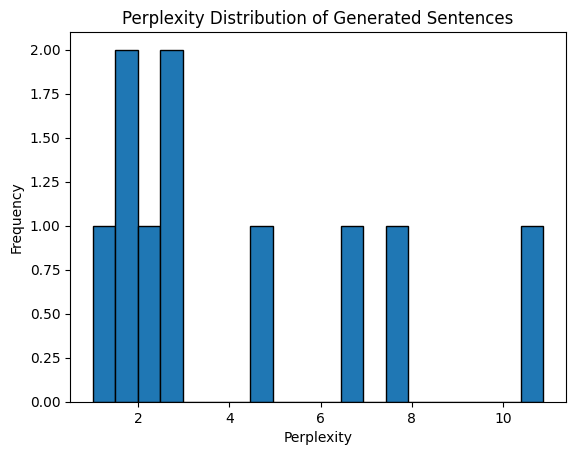

In [45]:
def calculate_perplexity(sentence, ngram_model, n, smoothing_factor=1e-10):
    """
    Calculate the perplexity of a sentence using the n-gram model with smoothing.
    """
    # Tokenize the input string back into a list of words
    tokens = sentence.split()
    
    # Generate n-grams
    ngrams = generate_ngrams(tokens, n)
    
    N = len(ngrams)
    if N == 0:
        return float('inf') # Avoid division by zero for very short strings
        
    log_prob_sum = 0
    
    for ngram in ngrams:
        context = tuple(ngram[:-1])
        word = ngram[-1]
        
        # Calculate Probability: count(context, word) / count(context)
        context_counts = ngram_model.get(context, {})
        total_context_occurrences = sum(context_counts.values())
        word_count = context_counts.get(word, 0)
        
        if total_context_occurrences > 0:
            probability = word_count / total_context_occurrences
        else:
            probability = 0
            
        # Apply smoothing if probability is 0
        if probability == 0:
            probability = smoothing_factor
            
        # Add the log of the probability
        log_prob_sum += math.log(probability)
        
    # Perplexity formula: exp( -1/N * sum(log_probs) )
    perplexity = math.exp(-1/N * log_prob_sum)
    
    return perplexity

# Calculate perplexity for generated sentences
perplexities = [calculate_perplexity(sentence, ngram_model, n) for sentence in generated_sentences]

# Plot the perplexity distribution
plt.hist(perplexities, bins=20, edgecolor='black')
plt.title('Perplexity Distribution of Generated Sentences')
plt.xlabel('Perplexity')
plt.ylabel('Frequency')
plt.show()